In [158]:
import thicket as th
from glob import glob

files = glob("group-cali-files/**/*.cali")
data = th.Thicket.from_caliperreader(files)

(2/2) Creating Thicket: 100%|██████████| 1392/1392 [00:24<00:00, 57.81it/s]


In [159]:
node_strings = ["comp_large", "comm", "main"]

In [160]:
data.metadata_columns_to_perfdata("input_size")
data.metadata_columns_to_perfdata("num_procs")
data.metadata_columns_to_perfdata("input_type")
data.metadata_columns_to_perfdata("algorithm")
data.metadata_columns_to_perfdata("cmdline")
data.metadata_columns_to_perfdata("opts:output")

In [161]:
df = data.dataframe
# df.head(50)
df[(df['algorithm'] == 'bitonic') & (df['input_size']
                                     == 268435456) & (df["input_type"] == 'Random') & (df['name'] == 'comm_large')]

nid  \
node                                       profile               
{'name': 'comm_large', 'type': 'function'} 252008057325    6.0   
                                           3541751142622   6.0   
                                           4889487626974   6.0   
                                           6626173607569   6.0   
                                           7739938748716   6.0   
                                           9713556402153   6.0   
                                           10291193069155  6.0   
                                           11279372351133  6.0   
                                           12026173843592  6.0   
                                           15434867550377  6.0   
                                           17493181976479  6.0   

                                                               spot.channel  \
node                                       profile                            
{'name': 'comm_large', 'type': 'function'} 252008057325    (regionprofile,)   
                                           3541751142622   (regionprofile,)   
                                           4889487626974   (regionprofile,)   
                                           6626173607569   (regionprofile,)   
                                           7739938748716   (regionprofile,)   
                                           9713556402153   (regionprofile,)   
                                           10291193069155  (regionprofile,)   
                                           11279372351133  (regionprofile,)   
                                           12026173843592  (regionprofile,)   
                                           15434867550377  (regionprofile,)   
                                           17493181976479  (regionprofile,)   

                                                           Min time/rank  \
node                                       profile                         
{'name': 'comm_large', 'type': 'function'} 252008057325         0.187676   
                                           3541751142622        0.113778   
                                           4889487626974        0.133229   
                                           6626173607569        0.113778   
                                           7739938748716        0.198919   
                                           9713556402153        0.153988   
                                           10291193069155       0.084813   
                                           11279372351133       0.103944   
                                           12026173843592       0.154339   
                                           15434867550377       0.170788   
                                           17493181976479       0.052851   

                                                           Max time/rank  \
node                                       profile                         
{'name': 'comm_large', 'type': 'function'} 252008057325         0.262897   
                                           3541751142622        0.113778   
                                           4889487626974        0.182658   
                                           6626173607569        0.113778   
                                           7739938748716        0.200599   
                                           9713556402153        0.268980   
                                           10291193069155       0.138681   
                                           11279372351133       0.143674   
                                           12026173843592       0.231164   
                                           15434867550377       0.173462   
                                           17493181976479       0.136411   

                                                           Avg time/rank  \
node                                       profile                         
{'name': 'comm_large', 'type': 'function'}

In [162]:
import matplotlib.pyplot as plt


def plot_runtimes(x, ys, leg_labels, title, figname, inp_size):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Time Strong Scaling (Input Size={inp_size})")
    ax.legend()
    # plt.savefig(f"plots/strong-time/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

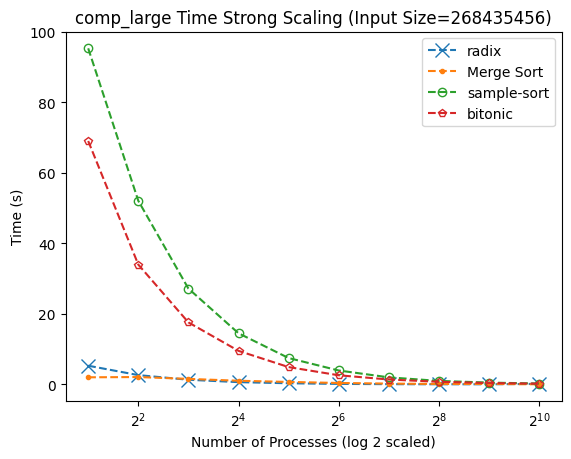

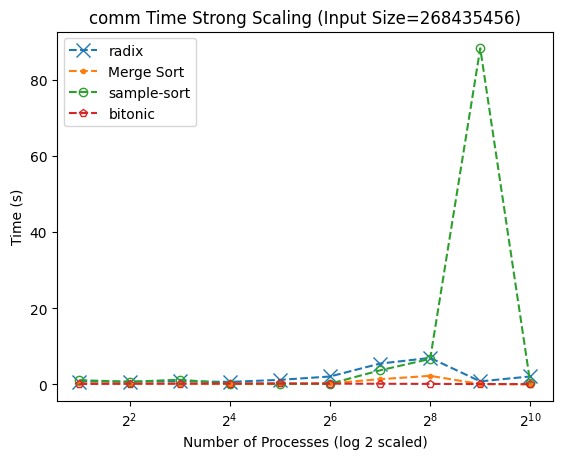

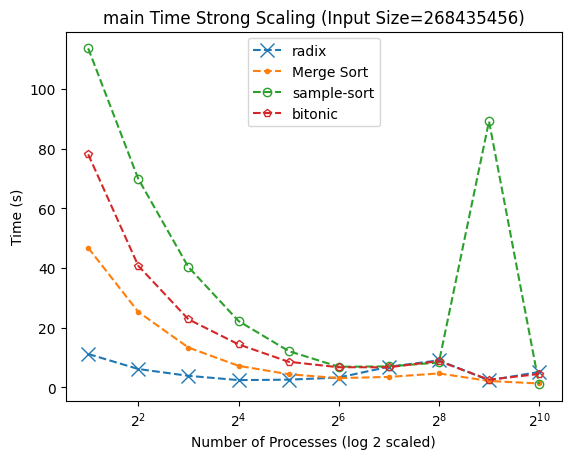

In [163]:
from copy import deepcopy


df = data.dataframe
df = df[df["Avg time/rank"].isna() == False]
data.dataframe = df

sub_data = data.groupby([ "algorithm", "input_size", "num_procs", "input_type"])
desired_size = 2**28
num_procs = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
algorithms = {"radix": [], "Merge Sort": [], "sample-sort" : [], "bitonic": []}

ys_time = {node : deepcopy(algorithms) for node in node_strings}

for cols, thic in sub_data.items():
    for node_string in node_strings:
        
        node = thic.get_node(node_string)
        algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
        sort_level = thic.dataframe.loc[node, "input_type"].values[0]
        inp_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])
        name = thic.dataframe.loc[node, "name"].values[0]
        if sort_level == 'random' or sort_level == "Random":
            sort_level = 2
        if (inp_size != desired_size or sort_level!=2):
            continue
        y_avg = float(thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])
        ys_time[node_string][algorithm].append(y_avg)

for node_string in node_strings:
    leg_labels = list(ys_time[node_string].keys())
    ys = list(ys_time[node_string].values())
    plot_runtimes(num_procs, ys, leg_labels, node_string, None, desired_size)

## Strong Scaling Speedup

In [164]:
def plot_speedup(x, ys, leg_labels, title, sort_level, figname):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Speedup Factor")
    ax.set_title(f"{title} Speedup Factor Strong Scaling (Sort Level={sort_level})")
    ax.legend()
    # plt.savefig(f"plots/strong-speedup/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

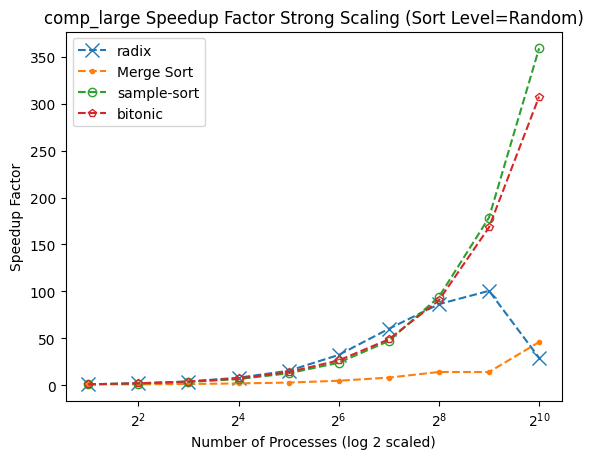

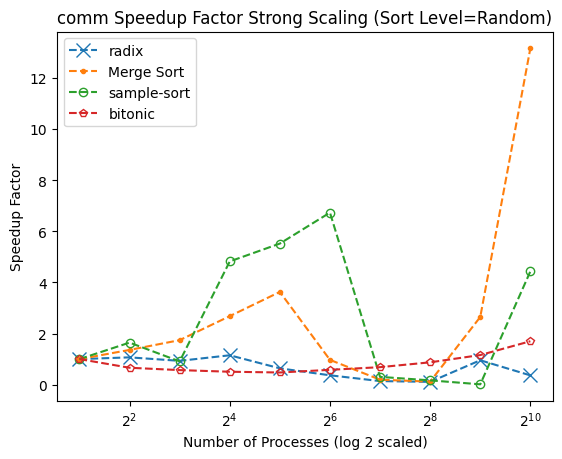

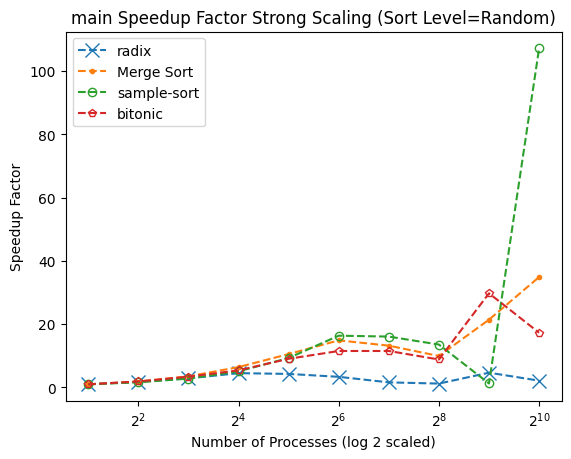

In [165]:
for node in node_strings:
    y_scaling = []
    for sort, times in ys_time[node].items():
        runtimes = times
        speedup = [runtimes[0]/x for x in runtimes]
        y_scaling.append(speedup)
    plot_speedup(num_procs, y_scaling, leg_labels, node, "Random", None)

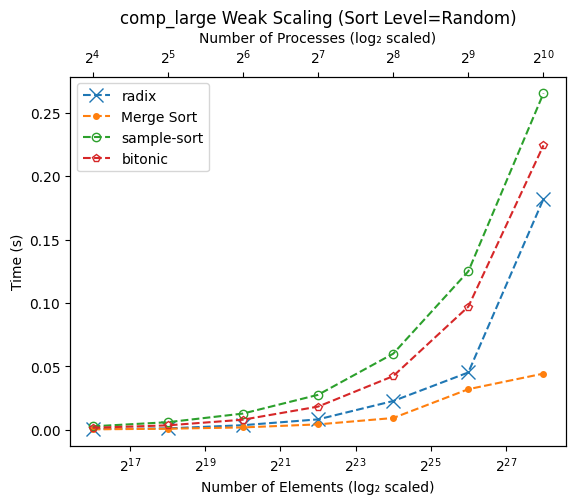

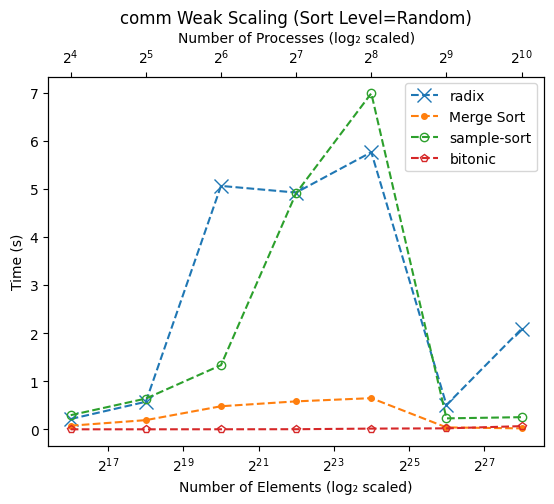

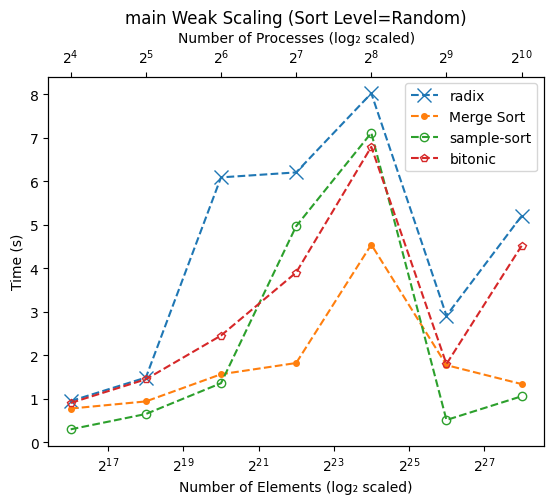

In [169]:
import matplotlib.pyplot as plt

df = data.dataframe
df = df[df["Avg time/rank"].isna() == False]
data.dataframe = df


def plot_runtimes_weak(x_proc, x_elem, ys, labels, title, sort_level, figname):
    """
    Plots weak scaling for two algorithms.

    Parameters:
    - x_proc: list of number of processes
    - x_elem: list of total number of elements
    - ys: list of two y-values lists [algo1_avg, algo2_avg]
    - labels: list of two algorithm names
    - title: region/node title
    - sort_level: e.g., 'Random'
    - figname: filename (unused if just showing)
    """
    _, ax = plt.subplots()
    ax2 = ax.twiny()

    # Plot two lines for the two algorithms
    ax.plot(x_elem, ys[0], 'x--', label=labels[0], markersize=10)
    ax.plot(x_elem, ys[1], '.--', label=labels[1], markersize=8)
    ax.plot(x_elem, ys[2], 'o--', label=labels[2], fillstyle='none')
    ax.plot(x_elem, ys[3], 'p--', label=labels[3], fillstyle='none')

    # Add invisible lines to link processes on top axis
    ax2.plot(x_proc, ys[0], alpha=0)
    ax2.plot(x_proc, ys[1], alpha=0)
    ax2.plot(x_proc, ys[2], alpha=0)
    ax2.plot(x_proc, ys[3], alpha=0)


    # Set log scales
    ax.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)

    # Labels
    ax.set_xlabel("Number of Elements (log₂ scaled)")
    ax2.set_xlabel("Number of Processes (log₂ scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Weak Scaling (Sort Level={sort_level})")
    ax.legend()
    plt.show()



import numpy as np
from itertools import product
from copy import deepcopy
int_to_string = {
    0: "Sorted",
    1: "Perturbed",
    2: "Random",
    3: "Reversed"
}
algorithms = {"radix": [], "Merge Sort": [], 'sample-sort': [], 'bitonic': []}

sub_data = data.groupby(["input_size", "num_procs", "input_type", 'algorithm'])
allowed_procs = [16, 32, 64, 128, 256, 512, 1024]
allowed_elems = [2**x for x in (16, 18, 20, 22, 24, 26, 28)]
allowed_combs = list(zip(allowed_procs, allowed_elems))

levels = {"Random"}
ys = {node: {alg: {level: deepcopy(metrics) for level in levels} for alg in algorithms.keys()}
      for node in node_strings}

for cols, thic in sub_data.items():
   for node_string in node_strings:

      node = thic.get_node(node_string)
      sort_level = thic.dataframe.loc[node, "input_type"].values[0]
      algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
      x_proc = int(thic.dataframe.loc[node, "num_procs"].values.flatten()[0])
      x_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])
      if sort_level == 'random' or sort_level == "Random":
         sort_level = 2
      if (((x_proc, x_size) not in allowed_combs) or sort_level != 2):
         continue
      sort_level = int_to_string[sort_level]

      y_avg = float(
          thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])
      ys[node_string][algorithm][sort_level]["Avg"].append(y_avg)


# Plot loop
for node_string in node_strings:
    for level in levels:
        ys_to_plot = []
        labels = []

        for algorithm in algorithms.keys():
            y_avg = ys[node_string][algorithm][level]["Avg"]
            if not y_avg:
                continue

            # Pad to match allowed_elems length
            y_avg += [np.nan]*(len(allowed_elems) - len(y_avg))
            ys_to_plot.append(y_avg)
            labels.append(algorithm)

        if len(ys_to_plot) != 4:
            continue  # skip if we don't have both algorithms

        plot_runtimes_weak(
            allowed_procs,
            allowed_elems,
            ys_to_plot,
            labels,
            node_string,
            level,
            f"{node_string}-{level}-weak"
        )